In [1]:
#import libraries
import pandas as pd
import string
import re
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import pickle
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
#reading the sentence dataset from tatoeba
sentences = pd.read_csv('/kaggle/input/tatoeba-sentences-updated-2023/sentences_detailed.csv', sep='\t', header= None, names =  ['id', 'lang', 'sentence', 'user', 'date1', 'date2'])

In [4]:
sentences

,id,lang,sentence,user,date1,date2
0,1,cmn,我們試試看！,sysko,\N,0000-00-00 00:00:00
1,2,cmn,我该去睡觉了。,fucongcong,\N,0000-00-00 00:00:00
2,3,cmn,你在干什麼啊？,sysko,\N,0000-00-00 00:00:00
3,4,cmn,這是什麼啊？,Martha,2008-09-08 09:20:59,0000-00-00 00:00:00
4,5,cmn,今天是６月１８号，也是Muiriel的生日！,Zifre,\N,0000-00-00 00:00:00
...,...,...,...,...,...,...
11594181,12057813,lvs,"Es mēģināšu to izdarīt, pirms Toms ieradīsies.",GemMonkey,2023-09-16 05:52:51,2023-09-16 05:52:51
11594182,12057814,lvs,Tas notika šī gada aprīlī.,GemMonkey,2023-09-16 05:53:35,2023-09-16 05:53:35
11594183,12057815,lvs,Ziri paslēpās aiz garāžas.,GemMonkey,2023-09-16 05:54:01,2023-09-16 05:54:01
11594184,12057816,lvs,Es dzīvoju mājā ar skatu uz pludmali.,GemMonkey,2023-09-16 05:55:13,2023-09-16 05:55:13


In [5]:
sentences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11594186 entries, 0 to 11594185
Data columns (total 6 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        int64 
 1   lang      object
 2   sentence  object
 3   user      object
 4   date1     object
 5   date2     object
dtypes: int64(1), object(5)
memory usage: 530.7+ MB


In [6]:
sentences.shape

(11594186, 6)

In [7]:
sentences['lang'].value_counts()

lang
eng    1826959
rus    1011865
ita     861829
tur     726974
epo     726829
        ...   
ssw          1
cyo          1
hax          1
urh          1
abq          1
Name: count, Length: 418, dtype: int64

In [8]:
#data preprocessing
languages = pd.DataFrame(columns=sentences.columns)


unique_languages = sentences['lang'].unique()
for lang in unique_languages:
    # Filter sentences for the current language
    lang_sentences = sentences[sentences['lang'] == lang]
    
    
    if len(lang_sentences) >= 200 :
        # Get 100 random sentences for each language
        lang_sentences = lang_sentences.sample(200, random_state=42)
        languages = pd.concat([languages, lang_sentences])
    elif 150 <= len(lang_sentences) <= 200:
        # Sample 100 random sentences for languages in the specified range
        lang_sentences = lang_sentences.sample(150, random_state=42)
        languages = pd.concat([languages, lang_sentences])
    elif 100 <= len(lang_sentences) <= 150:
        # Sample 100 random sentences for languages in the specified range
        lang_sentences = lang_sentences.sample(100, random_state=42)
        languages = pd.concat([languages, lang_sentences])
    
    

languages = languages.reset_index(drop=True)



In [9]:
languages

,id,lang,sentence,user,date1,date2
0,2140009,cmn,那對他依然奏效。,uhasan,2013-01-12 14:10:32,0000-00-00 00:00:00
1,895810,cmn,太郎上週買了一輛二手車。,Martha,2011-05-16 23:05:47,0000-00-00 00:00:00
2,1127057,cmn,據說他是世界上最富有的人。,nickyeow,2011-09-24 13:14:12,0000-00-00 00:00:00
3,333053,cmn,他不惜用私人时间来工作。,fucongcong,2009-06-11 00:53:31,0000-00-00 00:00:00
4,1593713,cmn,蜗牛壳是螺旋形的.,trieuho,2012-05-26 17:14:34,0000-00-00 00:00:00
...,...,...,...,...,...,...
41695,11991345,arn,Kimlafiñ mi rakizuamün.,puppetshow,2023-08-11 15:37:16,2023-08-11 15:37:16
41696,12008799,arn,Chumül akupaygün?,puppetshow,2023-08-22 04:45:35,2023-08-22 04:45:35
41697,12022258,arn,Wüle kullin ñi antüngeay.,puppetshow,2023-08-29 03:11:09,2023-08-29 03:11:09
41698,12022261,arn,Mütrümaen wüle.,puppetshow,2023-08-29 03:13:52,2023-08-29 03:13:52


In [10]:
languages['lang'].value_counts()

lang
cmn    200
pcd    200
mar    200
kir    200
prg    200
      ... 
afb    100
min    100
kal    100
ldn    100
lzz    100
Name: count, Length: 223, dtype: int64

In [11]:
#function for removing symbols and numbers from the sentences
def removeSymbolsAndNumbers(text):        
        text = re.sub(r'[{}]'.format(string.punctuation), '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[@]', '', text)

        return text.lower()

In [12]:
X1 = languages['sentence'].apply(removeSymbolsAndNumbers)
X1

0                        那對他依然奏效。
1                    太郎上週買了一輛二手車。
2                   據說他是世界上最富有的人。
3                    他不惜用私人时间来工作。
4                        蜗牛壳是螺旋形的
                   ...           
41695      kimlafiñ mi rakizuamün
41696            chumül akupaygün
41697    wüle kullin ñi antüngeay
41698              mütrümaen wüle
41699             tom purüy kafey
Name: sentence, Length: 41700, dtype: object

In [13]:
y = languages['lang']

In [14]:
#splitting the training and testing data
x_train, x_test, y_train, y_test = train_test_split(X1,y, random_state=42)

In [15]:
# Check for missing values in x_train
missing_x = x_train.isna().sum()

# Check for missing values in y_train
missing_y = y_train.isna().sum()

print("Missing values in x_train:", missing_x)
print("Missing values in y_train:", missing_y)


Missing values in x_train: 0
Missing values in y_train: 0


In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), analyzer='char')

In [17]:
model = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', LogisticRegression())
])

In [18]:
#training the model
model.fit(x_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('clf', LogisticRegression())])

In [19]:
#initializing prediction, accuracy and confusion matrix
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

In [20]:
#checking the accuracy
print("Accuracy is :",accuracy)

Accuracy is : 0.8217745803357314


In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          \N       0.75      0.22      0.34        41
         afb       1.00      0.05      0.09        22
         afr       0.91      0.90      0.90        58
         ain       0.79      0.90      0.84        50
         amh       0.96      0.96      0.96        54
         ang       0.93      0.93      0.93        45
         apc       0.00      0.00      0.00        20
         ara       0.45      0.65      0.53        48
         arg       1.00      0.29      0.45        31
         arn       0.89      0.94      0.91        50
         arq       0.62      0.80      0.70        50
         arz       0.53      0.55      0.54        56
         asm       0.98      0.96      0.97        51
         ast       0.44      0.61      0.51        38
         avk       0.66      0.82      0.73        49
         awa       0.92      0.80      0.86        41
         aze       1.00      0.83      0.91        58
         bak       0.98    

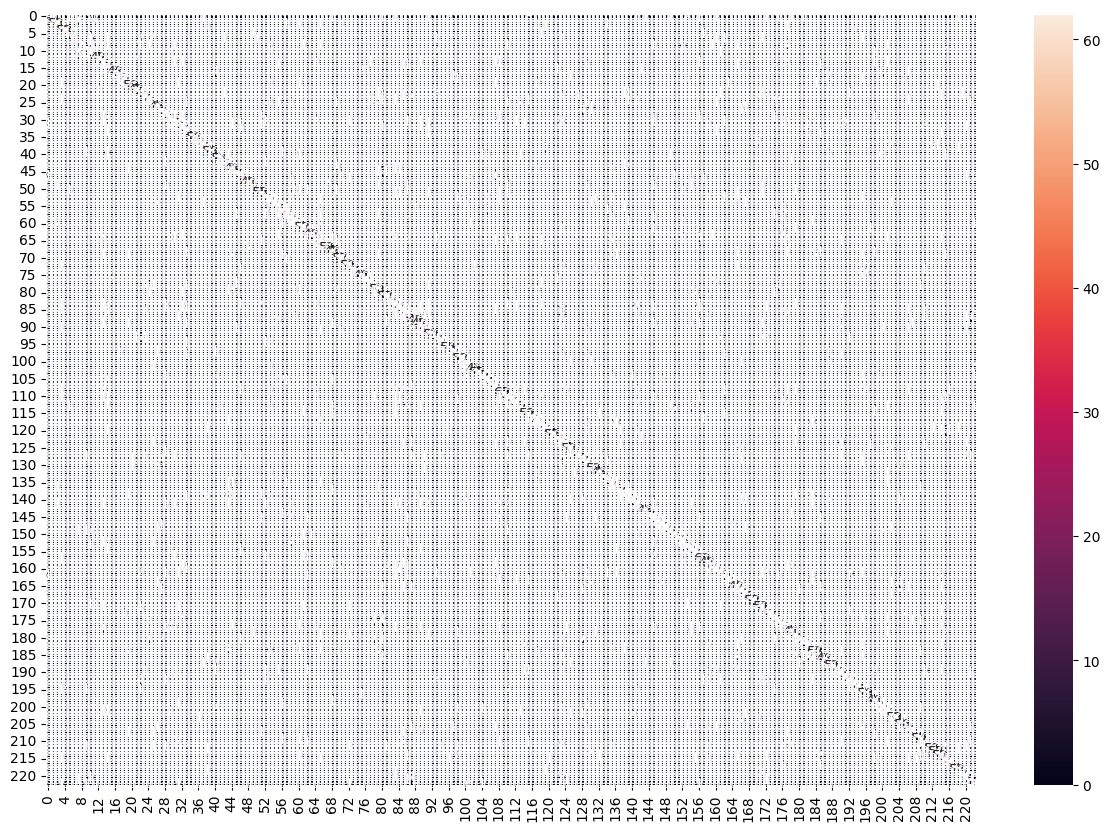

In [22]:
#plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True)
plt.show()

In [23]:
def predict(text):
    language = model.predict([text])
    print('The Language is in',language[0])

In [24]:
#predicting the language 
predict("こんにちは、元気ですか")#japanese
predict("hi how are you ")#english
predict("ஹாய் எப்படி இருக்கிறீர்கள் ")#tamil
predict("हैलो, क्या हाल हैं ")#hindi
predict("ഹായ്, സുഖമാണോ ")#malayalam
predict("как тебя зовут какое у тебя хобби")#russian
predict("hola, cómo estás ")#spanish
predict("VÉRIFICATION DU MODÈLE DE DÉTECTION DE LA LANGUE")#french
predict("توففحص نموذج الكشف عن اللغة")#arabic
predict("我們試試看！")#mandarin
predict("మీరు ఎలా ఉన్నారు")#telugu

The Language is in jpn
The Language is in eng
The Language is in tam
The Language is in hin
The Language is in mal
The Language is in rus
The Language is in spa
The Language is in fra
The Language is in ara
The Language is in cmn
The Language is in tel


In [25]:
#to save the model locally
import pickle
with open('lang_model.pkl','wb') as f:
    pickle.dump(model,f)